In [1]:
!pip install torch torchvision matplotlib seaborn scikit-learn


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
import os
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from torch.optim import lr_scheduler
from torchvision.models import regnet_y_8gf  # Latest RegNet variant

In [4]:
# Define data transformations for data augmentation and normalization
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        transforms.RandomRotation(30),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # ImageNet mean and std
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # ImageNet mean and std
    ]),
}

In [5]:

# Define the data directory
data_dir = '/content/drive/MyDrive/Images'

In [6]:
# Create data loaders
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16, shuffle=True, num_workers=4) for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
print(dataset_sizes)

class_names = image_datasets['train'].classes

{'train': 3902, 'test': 977}


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [7]:
# Load the pre-trained RegNetY model (you can choose different variants of RegNet like 400MF, 8GF, etc.)
model = regnet_y_8gf(pretrained=True)

# Efficiently modify the final fully connected layer for 6 classes
model.fc = nn.Linear(model.fc.in_features, 6)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=RegNet_Y_8GF_Weights.IMAGENET1K_V1`. You can also use `weights=RegNet_Y_8GF_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/regnet_y_8gf-d0d0e4a8.pth" to /root/.cache/torch/hub/checkpoints/regnet_y_8gf-d0d0e4a8.pth
100%|██████████| 151M/151M [00:03<00:00, 49.7MB/s]


In [8]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Use Adam optimizer for better convergence

# Learning Rate Scheduler (use cosine annealing for RegNet’s dynamic scaling)
scheduler = lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

# Move the model to the GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [9]:
# Training loop with dynamic scheduler and more efficient processing
num_epochs = 15
best_model_wts = model.state_dict()
best_acc = 0.0
train_losses, test_losses = [], []
train_accs, test_accs = [], []

for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}')
    print('-' * 10)

    for phase in ['train', 'test']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0
        running_corrects = 0

        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]
        if phase == 'train':
            train_losses.append(epoch_loss)
            train_accs.append(epoch_acc)
        else:
            test_losses.append(epoch_loss)
            test_accs.append(epoch_acc)

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # Deep copy the model if it achieves better performance
        if phase == 'test' and epoch_acc > best_acc:
            best_acc = epoch_acc
            best_model_wts = model.state_dict()

    scheduler.step()  # Update learning rate using cosine annealing

# Load best model weights
model.load_state_dict(best_model_wts)

Epoch 1/15
----------
train Loss: 0.8761 Acc: 0.6991
test Loss: 0.7128 Acc: 0.7851
Epoch 2/15
----------
train Loss: 0.5385 Acc: 0.8175
test Loss: 0.3064 Acc: 0.8915
Epoch 3/15
----------
train Loss: 0.4485 Acc: 0.8432
test Loss: 0.1877 Acc: 0.9314
Epoch 4/15
----------
train Loss: 0.3551 Acc: 0.8842
test Loss: 0.1486 Acc: 0.9529
Epoch 5/15
----------
train Loss: 0.3039 Acc: 0.8949
test Loss: 0.1022 Acc: 0.9683
Epoch 6/15
----------
train Loss: 0.2500 Acc: 0.9188
test Loss: 0.0527 Acc: 0.9826
Epoch 7/15
----------
train Loss: 0.2000 Acc: 0.9341
test Loss: 0.0382 Acc: 0.9867
Epoch 8/15
----------
train Loss: 0.1709 Acc: 0.9441
test Loss: 0.0461 Acc: 0.9846
Epoch 9/15
----------
train Loss: 0.1333 Acc: 0.9564
test Loss: 0.0397 Acc: 0.9785
Epoch 10/15
----------
train Loss: 0.1092 Acc: 0.9634
test Loss: 0.0342 Acc: 0.9826
Epoch 11/15
----------
train Loss: 0.0915 Acc: 0.9669
test Loss: 0.0376 Acc: 0.9826
Epoch 12/15
----------
train Loss: 0.1070 Acc: 0.9654
test Loss: 0.0304 Acc: 0.9867
E

<All keys matched successfully>

In [10]:
# Save the trained model
torch.save(model.state_dict(), 'best_classification_model_regnet.pth')

In [11]:
# Evaluate model performance
def evaluate_model(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloaders['test']:  # Using test set for evaluation
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    cm = confusion_matrix(all_labels, all_preds)
    cr = classification_report(all_labels, all_preds, target_names=class_names)
    return cm, cr

# Get confusion matrix and classification report
cm, cr = evaluate_model(model, dataloaders['test'])
print("Classification Report:\n", cr)


Classification Report:
                   precision    recall  f1-score   support

          Aphids       0.99      0.96      0.98       164
       Army worm       0.96      1.00      0.98       162
Bacterial blight       0.99      0.97      0.98       160
         Healthy       0.98      1.00      0.99       165
  Powdery mildew       0.99      1.00      1.00       166
     Target spot       0.98      0.96      0.97       160

        accuracy                           0.98       977
       macro avg       0.98      0.98      0.98       977
    weighted avg       0.98      0.98      0.98       977



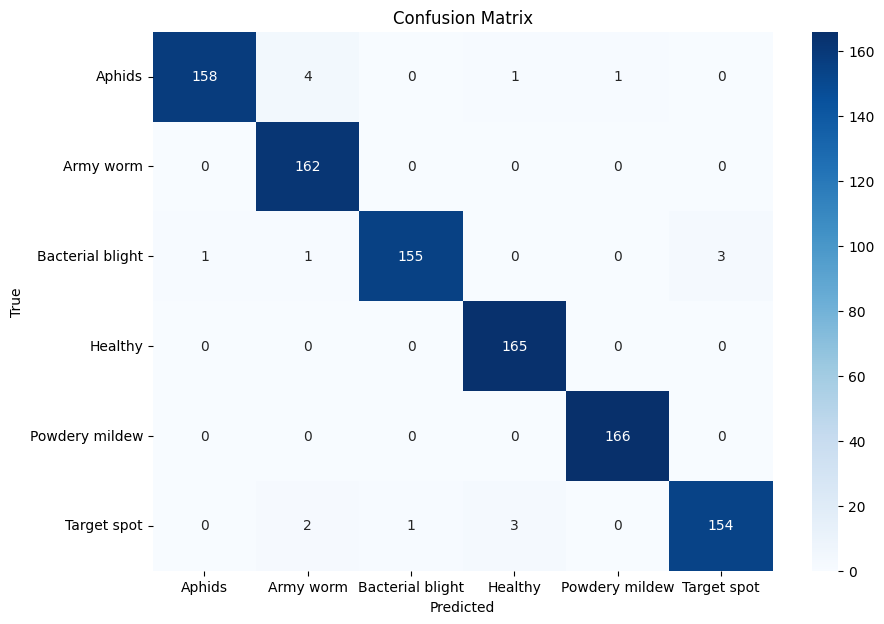

In [12]:
# Visualize Confusion Matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

The predicted class is: Target spot with a confidence of 0.7808


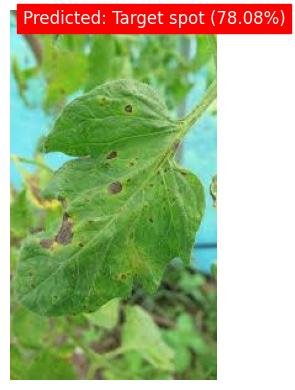

In [22]:
from PIL import Image
# Example image prediction with probabilities
image_path = '/content/target.jpeg'  # Replace with your test image path
image = Image.open(image_path)
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
input_tensor = preprocess(image)
input_batch = input_tensor.unsqueeze(0).to(device)

# Perform inference
model.eval()
with torch.no_grad():
    output = model(input_batch)
    probabilities = torch.nn.functional.softmax(output, dim=1)
    confidence, predicted_class = torch.max(probabilities, 1)

# Get predicted class and probability
predicted_class_name = class_names[predicted_class.item()]
predicted_prob = probabilities[0][predicted_class].item()

print(f'The predicted class is: {predicted_class_name} with a confidence of {predicted_prob:.4f}')

# Show the image with prediction
plt.imshow(np.array(image))
plt.axis('off')
plt.text(10, 10, f'Predicted: {predicted_class_name} ({predicted_prob*100:.2f}%)', fontsize=12, color='white', backgroundcolor='red')
plt.show()




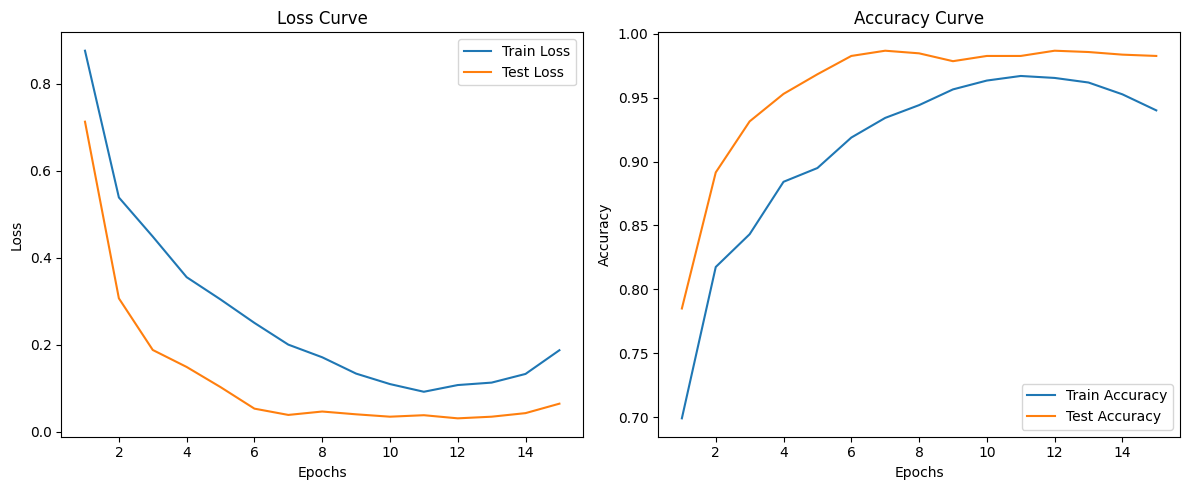

In [20]:
# Ensure all tensors in train_accs and test_accs are converted to Python floats
train_accs = [acc.cpu().item() if isinstance(acc, torch.Tensor) else acc for acc in train_accs]
test_accs = [acc.cpu().item() if isinstance(acc, torch.Tensor) else acc for acc in test_accs]

# Plotting
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, test_losses, label='Test Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Accuracy plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accs, label='Train Accuracy')
plt.plot(epochs, test_accs, label='Test Accuracy')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
